In [1]:
!pip install optuna

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import optuna
from optuna.trial import TrialState
import numpy as np
from sklearn.metrics import roc_auc_score
import random
from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(4201)

cuda


In [4]:
faces = np.load("/kaggle/input/olivetti/olivetti_faces.npy")
labels = np.load("/kaggle/input/olivetti/olivetti_faces_target.npy")

In [5]:
print(f"Shape of input features {faces.shape}")
print(f"unique labels {len(np.unique(labels))}")

Shape of input features (400, 64, 64)
unique labels 40


In [6]:
def make_pairs(images,labels):
    pair_images = []
    pair_labels = []
    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
    num_classes = len(label_to_indices)
    for label in np.unique(labels):
        indices = label_to_indices[label]
        for idx in indices:
            # Positive pair (same label)
            pos_idx = np.random.choice(indices)
            pair_images.append([images[idx], images[pos_idx]])
            pair_labels.append(0)
            
            # Negative pair (different label)
            neg_label = random.choice([l for l in range(num_classes) if l != label])
            neg_idx = np.random.choice(label_to_indices[neg_label])
            pair_images.append([images[idx], images[neg_idx]])
            pair_labels.append(1)
            
    return np.array(pair_images), np.array(pair_labels)

pair_images, pair_labels = make_pairs(faces, labels)

print(f"Generated {len(pair_images)} pairs (half positive, half negative)")
    

Generated 800 pairs (half positive, half negative)


In [7]:
pair_images[2],pair_labels[2]

(array([[[0.45454547, 0.47107437, 0.5123967 , ..., 0.19008264,
          0.18595041, 0.18595041],
         [0.446281  , 0.48347107, 0.5206612 , ..., 0.21487603,
          0.2107438 , 0.2107438 ],
         [0.49586776, 0.5165289 , 0.53305787, ..., 0.20247933,
          0.20661157, 0.20661157],
         ...,
         [0.77272725, 0.78099173, 0.7933884 , ..., 0.1446281 ,
          0.1446281 , 0.1446281 ],
         [0.77272725, 0.7768595 , 0.7892562 , ..., 0.13636364,
          0.13636364, 0.13636364],
         [0.7644628 , 0.7892562 , 0.78099173, ..., 0.15289256,
          0.15289256, 0.15289256]],
 
        [[0.5       , 0.54545456, 0.58264464, ..., 0.2231405 ,
          0.2231405 , 0.2231405 ],
         [0.47933885, 0.5123967 , 0.58264464, ..., 0.20247933,
          0.20247933, 0.20247933],
         [0.49173555, 0.5413223 , 0.59504133, ..., 0.21487603,
          0.21487603, 0.21487603],
         ...,
         [0.4752066 , 0.41735536, 0.40082645, ..., 0.19421488,
          0.19421488, 0.

In [8]:
class FaceDataset(Dataset):
    def __init__(self,pair_images,pair_labels,transform=None):
        self.pair_images = pair_images
        self.pair_labels = pair_labels
        self.transform = transform

    def __len__(self):
        return len(self.pair_images)

    def __getitem__(self,idx):
        img1,img2 = self.pair_images[idx]
        labels = self.pair_labels[idx]

        img1 = self.transform(img1)
        img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(labels, dtype=torch.float32)


        
        

In [9]:
face_transforms = transforms.Compose([
    transforms.ToPILImage(),                  #convert np array to PIL image
    transforms.Resize((64, 64)),              # ensure consistent size across all images
    transforms.RandomApply([                  # apply augmentations randomly
        transforms.RandomRotation(10),        # random rotation
        transforms.RandomResizedCrop(64, scale=(0.9, 1.1)), # zoom in/out
        transforms.RandomHorizontalFlip(),    # horizontal flip
    ], p=0.5),                                # 50% chance applying the random transformations
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [10]:
dataset = FaceDataset(pair_images,pair_labels,face_transforms)
batch_size=32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Get dataset size
dataset_size = len(dataset)

# Compute split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # ensure full coverage

# Split dataset
generator1= torch.Generator().manual_seed(4201)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],generator=generator1)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
for img1,img2,labels in train_loader:
    print(img1.shape,img2.shape)
    break

torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 64, 64])


In [13]:
class SimilarityModel(nn.Module):
    """
    Siamese CNN that generates embeddings for face similarity comparison.
    """

    def __init__(self, embedding_dim, conv1_filter, conv2_filter, conv3_filter, dropout_rate=0.3):
        super().__init__()

        # Convolutional feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, conv1_filter, kernel_size=3, padding=2),
            nn.BatchNorm2d(conv1_filter),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(conv1_filter, conv2_filter, kernel_size=3, padding=2),
            nn.BatchNorm2d(conv2_filter),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(conv2_filter, conv3_filter, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv3_filter),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Embedding network
        self.embedding = nn.Sequential(
            nn.Linear(conv3_filter * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, embedding_dim),
        )

    def forward_once(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        return F.normalize(x, p=2, dim=1)  # L2 normalization

    def forward(self, x1, x2):
        emb1 = self.forward_once(x1)
        emb2 = self.forward_once(x2)
        return emb1, emb2

In [14]:
def contrastive_loss(emb1, emb2, labels, margin=1.0):
    distances = F.pairwise_distance(emb1, emb2)
    loss_same = (1 - labels) * torch.pow(distances, 2)
    loss_diff = labels * torch.pow(torch.clamp(margin - distances, min=0.0), 2)
    return (loss_same + loss_diff).mean()

In [15]:
def train_epoch(model, dataloader, optimizer, device, margin=1.0):
    model.train()
    total_loss = 0.0

    for img1, img2, labels in dataloader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        emb1, emb2 = model(img1, img2)
        loss = contrastive_loss(emb1, emb2, labels, margin)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
def validate(model, dataloader, device, margin=1.0):
    model.eval()
    total_loss = 0.0
    all_distances, all_labels = [], []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            emb1, emb2 = model(img1, img2)
            loss = contrastive_loss(emb1, emb2, labels, margin)
            distances = F.pairwise_distance(emb1, emb2)

            total_loss += loss.item()
            all_distances.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    try:
        auc = roc_auc_score(all_labels, all_distances)
    except ValueError:
        auc = 0.5

    return total_loss / len(dataloader), auc

In [17]:
def objective(trial, train_loader, val_loader, device, n_epochs=20):
    # Suggest hyperparameters
    embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256, 512])
    conv1_filter = trial.suggest_categorical("conv1_filter", [16, 32, 64])
    conv2_filter = trial.suggest_categorical("conv2_filter", [32, 64, 128])
    conv3_filter = trial.suggest_categorical("conv3_filter", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    lr = trial.suggest_categorical("lr", [1e-5,1e-4,1e-3,1e-2])
    margin = trial.suggest_float("margin", 0.5, 2.0)
    weight_decay = trial.suggest_categorical("weight_decay", [1e-6,1e-5,1e-4,1e-3])
    # Create model
    model = SimilarityModel(embedding_dim, conv1_filter, conv2_filter, conv3_filter, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)

    best_auc = 0.0

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device, margin)
        val_loss, val_auc = validate(model, val_loader, device, margin)
        scheduler.step(val_loss)

        best_auc = max(best_auc, val_auc)
        trial.report(val_auc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_auc

In [18]:
def run_optuna_study(train_loader, val_loader, n_trials=50, n_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
    study.optimize(lambda t: objective(t, train_loader, val_loader, device, n_epochs), n_trials=n_trials, show_progress_bar=True)

    print("\n" + "=" * 80)
    print("OPTIMIZATION COMPLETE")
    print("=" * 80)
    print(f"Best AUC: {study.best_trial.value:.4f}")
    print("Best Parameters:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    return study

In [19]:
def train_final_model(best_params, train_loader, val_loader, n_epochs=50, save_path="best_model.pth", patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimilarityModel(
        best_params["embedding_dim"],
        best_params["conv1_filter"],
        best_params["conv2_filter"],
        best_params["conv3_filter"],
        best_params["dropout_rate"]
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)
    
    best_auc = 0.0
    epochs_without_improvement = 0
    margin = best_params["margin"]
    
    print("\nTraining final model...")
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device, margin)
        val_loss, val_auc = validate(model, val_loader, device, margin)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f}")
        
        if val_auc > best_auc:
            best_auc = val_auc
            epochs_without_improvement = 0
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "auc": best_auc,
                "hyperparameters": best_params
            }, save_path)
            print(f"  ✓ Model saved (AUC: {best_auc:.4f})")
        else:
            epochs_without_improvement += 1
            print(f"  No improvement for {epochs_without_improvement} epoch(s)")
            
            if epochs_without_improvement >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                print(f"No improvement for {patience} consecutive epochs")
                break
    
    print(f"\nTraining complete! Best AUC: {best_auc:.4f}")
    return model

In [20]:
def compute_embedding(model, image, device):
    model.eval()
    with torch.no_grad():
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
        return model.forward_once(image)

In [21]:
def verify_faces(model, img1, img2, threshold=0.6, device="cpu"):
    """
    Verify if two faces belong to the same person.
    """
    emb1 = compute_embedding(model, img1, device)
    emb2 = compute_embedding(model, img2, device)
    distance = F.pairwise_distance(emb1, emb2).item()

    is_same = distance < threshold
    confidence = max(0, 1 - distance / 2)
    return is_same, distance, confidence

In [22]:
if __name__ == '__main__':
    study = run_optuna_study(train_loader, val_loader, n_trials=20, n_epochs=10)

    # Train final model
    best_model = train_final_model(study.best_params, train_loader, val_loader, n_epochs=100)


[I 2025-11-08 11:42:52,648] A new study created in memory with name: no-name-c183ee4f-c468-4f75-a33c-f79979402473



Using device: cuda


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-08 11:43:04,824] Trial 0 finished with value: 0.9891183035714286 and parameters: {'embedding_dim': 64, 'conv1_filter': 64, 'conv2_filter': 32, 'conv3_filter': 128, 'dropout_rate': 0.17707414042341446, 'lr': 0.0001, 'margin': 1.3583680902829995, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.9891183035714286.
[I 2025-11-08 11:43:15,413] Trial 1 finished with value: 0.9243861607142857 and parameters: {'embedding_dim': 128, 'conv1_filter': 64, 'conv2_filter': 64, 'conv3_filter': 64, 'dropout_rate': 0.2583913751654239, 'lr': 1e-05, 'margin': 1.9423449059422737, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.9891183035714286.
[I 2025-11-08 11:43:24,543] Trial 2 finished with value: 0.9447544642857142 and parameters: {'embedding_dim': 512, 'conv1_filter': 16, 'conv2_filter': 32, 'conv3_filter': 64, 'dropout_rate': 0.1674542622743407, 'lr': 1e-05, 'margin': 1.7722956767526554, 'weight_decay': 1e-06}. Best is trial 0 with value: 0.9891183035714286.
[I 2025-11-08 11:43

In [25]:
# Load saved model
best_params = study.best_params

model = SimilarityModel(
    best_params["embedding_dim"],
    best_params["conv1_filter"],
    best_params["conv2_filter"],
    best_params["conv3_filter"],
    best_params["dropout_rate"]
).to(device)

# Load checkpoint
checkpoint = torch.load("/kaggle/working/best_model.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Test evaluation
test_loss = 0.0
all_distances, all_labels = [], []

with torch.no_grad():  # no gradients needed during evaluation
    for img1, img2, labels in test_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        emb1, emb2 = model(img1, img2)
        loss = contrastive_loss(emb1, emb2, labels)
        test_loss += loss.item()

        distances = F.pairwise_distance(emb1, emb2)
        all_distances.extend(distances.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute AUC
test_auc = roc_auc_score(all_labels, all_distances)

print(f"✅ Test Loss: {test_loss / len(test_loader):.4f}")
print(f"✅ Test AUC:  {test_auc:.4f}")


✅ Test Loss: 0.0934
✅ Test AUC:  0.9721


In [26]:
def load_model(checkpoint_path, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    hp = checkpoint['hyperparameters']
    
    model = SimilarityModel(
        hp['embedding_dim'], hp['conv1_filter'], 
        hp['conv2_filter'], hp['conv3_filter'], hp['dropout_rate']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, device

def predict(model, img_path1, img_path2, device, threshold=0.4, show_images=True):
    import matplotlib.pyplot as plt
    
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Load original images for display
    orig_img1 = Image.open(img_path1).convert('L')
    orig_img2 = Image.open(img_path2).convert('L')
    
    # Transform for model
    img1 = transform(orig_img1).unsqueeze(0).to(device)
    img2 = transform(orig_img2).unsqueeze(0).to(device)
    
    with torch.no_grad():
        emb1, emb2 = model(img1, img2)
        distance = F.pairwise_distance(emb1, emb2).item()
    
    is_same = distance < threshold
    confidence = max(0, 1 - distance / 2)
    
    print(f"{'SAME PERSON' if is_same else 'DIFFERENT PERSON'}")
    print(f"Distance: {distance:.4f} | Confidence: {confidence:.2%}")
    
    # Show images
    if show_images:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].imshow(orig_img1, cmap='gray')
        axes[0].set_title('Image 1')
        axes[0].axis('off')
        
        axes[1].imshow(orig_img2, cmap='gray')
        axes[1].set_title('Image 2')
        axes[1].axis('off')
        
        verdict = "SAME PERSON" if is_same else "DIFFERENT PERSON"
        color = 'green' if is_same else 'red'
        
        fig.suptitle(
            f"{verdict}\nDistance: {distance:.4f} | Confidence: {confidence:.2%}",
            fontsize=14, fontweight='bold', color=color
        )
        
        plt.tight_layout()
        plt.show()
    
    return is_same, distance, confidence

DIFFERENT PERSON
Distance: 0.6276 | Confidence: 68.62%


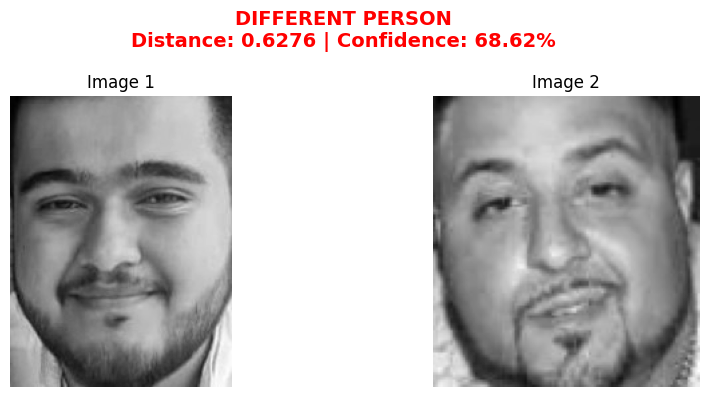

(False, 0.6276037096977234, 0.6861981451511383)

In [34]:
model, device = load_model('/kaggle/working/best_model.pth')
predict(model, "/kaggle/input/facessada/ab1.jpg" , "/kaggle/input/facessada/dj1.jpg", device, threshold=0.62)

SAME PERSON
Distance: 0.4768 | Confidence: 76.16%


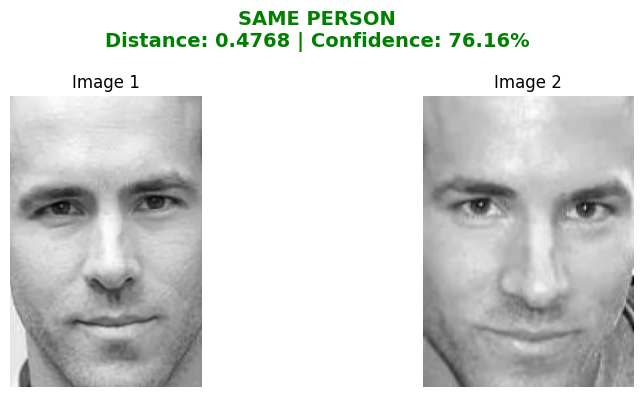

(True, 0.47678929567337036, 0.7616053521633148)

In [39]:
predict(model, "/kaggle/input/facessada/ryan1.jpg" , "/kaggle/input/facessada/ryan2.jpg", device, threshold=0.62)